<a href="https://colab.research.google.com/github/Steriva/PINNs-pyTorch/blob/master/PINN_ODEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-Informed Neural Network for parametric ODEs
This notebook implements the basic tools using *pyTorch* to build from scratch a PINN for an ODE, e. g.
\begin{equation}
\frac{d f}{dt}=R\cdot t(1-t)
\end{equation}
given $f(0)=1$. The package for Automatic Differentiation (AD) is used to compute derivatives (AD is actually what made neural networks so efficient and successful in the first place).

This notebook is based on [Mario Dagrada's Tutorial](https://towardsdatascience.com/solving-differential-equations-with-neural-networks-afdcf7b8bcc4).

At first, a PINN class is defined for the topology of the net: it it takes as input the number of layers (excluding input) and the hidden dimension of the layers, the activation is by default an hyperbolic tangent, even though it can be changed.

In [ ]:
!pip install pyDOE

In [2]:
import torch
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

A class which takes as input a list with the number of neurons per each layer is defined.

In [3]:
from torch import nn
from collections import OrderedDict

class NeuralNet(nn.Module):
    """Simple neural network accepting one feature as input and returning a single output
    
    In the context of PINNs, the neural network is used as universal function approximator
    to approximate the solution of the differential equation
    """    
    def __init__(self, layers: list, act=nn.Tanh()):
        super(NeuralNet, self).__init__()

        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = nn.Sequential(layerDict)

    def forward(self, x):
        return self.layers(x)
        

## Logistic Equation
Let us consider the following ODE, a logistic equation
\begin{equation}
\frac{d f}{dt}=R\cdot t(1-t)
\end{equation}
given $f(0)=1$, the following functions are used to train a Neural Network considering $R=1$.

In [4]:
from typing import Callable

def f(nn: NeuralNet, x: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return nn(x)


def df(nn: NeuralNet, x: torch.Tensor = None, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = f(nn, x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value


def compute_loss(
    nn: NeuralNet, x: torch.Tensor = None, verbose: bool = False
) -> torch.float:
    """Compute the full loss function as interior loss + boundary loss
    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """

    interior_loss = df(nn, x) - 1. * x**2 * (1 - x)

    boundary = torch.Tensor([0.0])
    boundary.requires_grad = True
    boundary_loss = f(nn, boundary) - 1.
    final_loss = interior_loss.pow(2).mean() + boundary_loss ** 2
    return final_loss, interior_loss.pow(2).mean(), boundary_loss ** 2


def train_model(
    nn: NeuralNet,
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000,
) -> NeuralNet:

    loss_evolution = []

    optimizer = torch.optim.SGD(nn.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):

        try:

            loss, residual_loss, boundary_loss = loss_fn(nn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1000 == 0:
                print(f'Iter {epoch+0:06} | Loss: {float(loss):.3e} | Residual: {float(residual_loss):.3e} | Boundary: {float(boundary_loss):.3e}')
            loss_evolution.append(loss.detach().numpy())

        except KeyboardInterrupt:
            break

    return nn, np.array(loss_evolution)

Let us train this net considering 20 steps inside the domain, uniformly spaced.

In [5]:
from functools import partial

domain = [0.0, 1.0]
x = torch.linspace(domain[0], domain[1], steps=20, requires_grad=True)
x = x.reshape(x.shape[0], 1)


layers = [1, 10, 10, 10, 1]
nn_approximator = NeuralNet(layers)
loss_fn = partial(compute_loss, x=x, verbose=True)
nn_approximator_trained, loss_evolution = train_model(
    nn_approximator, loss_fn=loss_fn, learning_rate=0.1, max_epochs=20_000
)

Iter 000000 | Loss: 9.880e-01 | Residual: 8.907e-03 | Boundary: 9.791e-01
Iter 001000 | Loss: 1.213e-03 | Residual: 1.213e-03 | Boundary: 4.106e-09
Iter 002000 | Loss: 8.854e-04 | Residual: 8.854e-04 | Boundary: 1.098e-09
Iter 003000 | Loss: 7.161e-04 | Residual: 7.161e-04 | Boundary: 1.879e-10
Iter 004000 | Loss: 6.562e-04 | Residual: 6.562e-04 | Boundary: 9.095e-13
Iter 005000 | Loss: 6.170e-04 | Residual: 6.170e-04 | Boundary: 4.299e-11
Iter 006000 | Loss: 5.801e-04 | Residual: 5.801e-04 | Boundary: 7.994e-11
Iter 007000 | Loss: 5.437e-04 | Residual: 5.437e-04 | Boundary: 1.126e-10
Iter 008000 | Loss: 5.072e-04 | Residual: 5.072e-04 | Boundary: 1.508e-10
Iter 009000 | Loss: 4.702e-04 | Residual: 4.702e-04 | Boundary: 1.912e-10
Iter 010000 | Loss: 4.323e-04 | Residual: 4.323e-04 | Boundary: 2.439e-10
Iter 011000 | Loss: 3.932e-04 | Residual: 3.932e-04 | Boundary: 2.988e-10
Iter 012000 | Loss: 3.526e-04 | Residual: 3.526e-04 | Boundary: 3.503e-10
Iter 013000 | Loss: 3.104e-04 | Residu

In the end, let us compare the NN solution which respect to a numerical calculation, for this simple case, also an analytical solution is possible.

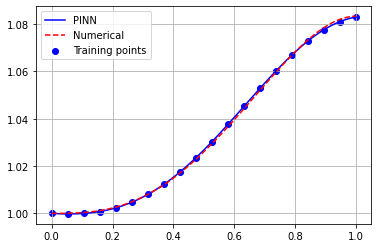

In [6]:
x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)

# numeric solution
def logistic_eq_fn(x, y):
    return 1. * x**2 * (1 - x)

import time

numerical_time = time.time()
numeric_solution = solve_ivp(
    logistic_eq_fn, domain, [1.], t_eval=x_eval.squeeze().detach().numpy()
)
numerical_time = time.time() - numerical_time

PINN_time = time.time()
f_final_training = f(nn_approximator_trained, x)
f_final = f(nn_approximator_trained, x_eval)
PINN_time = time.time() - PINN_time

plt.scatter(x.detach().numpy(), f_final_training.detach().numpy(), label="Training points", color="b")

plt.plot(x_eval, f_final.detach().numpy(),'b', label='PINN')

plt.plot(x_eval, numeric_solution.y.T, 'r--', label = 'Numerical')

plt.legend()
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')

### Parametric version of the PINN
In the previous framework, the coefficient $R$ was supposed to be constant and equal to 1. We would like to see if we can train the NN to solve the parametric ODE.

In [7]:
# the physics-guided neural network
class PINN_population():
    def __init__(self, IC, CollocationPts, layers):
        
        # data
        self.t0  = torch.zeros([len(CollocationPts), 1]).to(device)
        self.IC  = torch.tensor(IC).float().to(device)
        self.t_f = torch.tensor(CollocationPts[:, 0:1], requires_grad=True).float().to(device)
        self.R_f = torch.tensor(CollocationPts[:, 1:2], requires_grad=True).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = NeuralNet(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"      
        )
        
        self.iter = 0
        
    def net_u(self, t, R):  
        u = self.dnn(torch.cat([t, R], dim=1))
        return u
    
    def net_f(self, t, R):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(t, R)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        return u_t - R * t * (1-t)
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.t0, self.R_f)
        f_pred = self.net_f(self.t_f, self.R_f)
        loss_u = torch.mean((self.IC - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 20 == 0:
            print(f'Iter {self.iter+0:06} | Loss: {loss.item():.3e} | Loss_u: {loss_u.item():.3e}| Loss_f: {loss_f.item():.3e}')
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

    def predict(self, X):
        t = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        R = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(t, R)
        f = self.net_f(t, R)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

Let us train the net

In [8]:
from pyDOE import lhs
IC = 1.

lb = np.array([0, 0.5])
ub = np.array([1, 1.5])

X_f_train = lb + (ub-lb)*lhs(2, 25)

layers = [2, 10, 10, 1]
model = PINN_population(IC, X_f_train, layers)
model.train()

Iter 000020 | Loss: 4.988e-03 | Loss_u: 2.224e-04| Loss_f: 4.765e-03
Iter 000040 | Loss: 6.965e-03 | Loss_u: 2.710e-03| Loss_f: 4.255e-03
Iter 000060 | Loss: 2.687e-04 | Loss_u: 6.868e-06| Loss_f: 2.618e-04
Iter 000080 | Loss: 1.521e-04 | Loss_u: 1.445e-05| Loss_f: 1.377e-04
Iter 000100 | Loss: 1.057e-04 | Loss_u: 3.972e-06| Loss_f: 1.018e-04
Iter 000120 | Loss: 4.524e-05 | Loss_u: 1.483e-06| Loss_f: 4.375e-05
Iter 000140 | Loss: 3.127e-05 | Loss_u: 1.298e-07| Loss_f: 3.114e-05
Iter 000160 | Loss: 2.591e-05 | Loss_u: 2.026e-08| Loss_f: 2.589e-05
Iter 000180 | Loss: 1.863e-05 | Loss_u: 9.045e-07| Loss_f: 1.772e-05
Iter 000200 | Loss: 1.632e-05 | Loss_u: 2.184e-06| Loss_f: 1.413e-05
Iter 000220 | Loss: 1.334e-05 | Loss_u: 9.065e-07| Loss_f: 1.243e-05
Iter 000240 | Loss: 1.089e-05 | Loss_u: 6.111e-07| Loss_f: 1.028e-05
Iter 000260 | Loss: 6.181e-06 | Loss_u: 1.210e-06| Loss_f: 4.971e-06
Iter 000280 | Loss: 5.128e-06 | Loss_u: 4.188e-07| Loss_f: 4.709e-06
Iter 000300 | Loss: 3.748e-06 | Lo

Then, the prediction is compared with the numerical solution using scipy package.

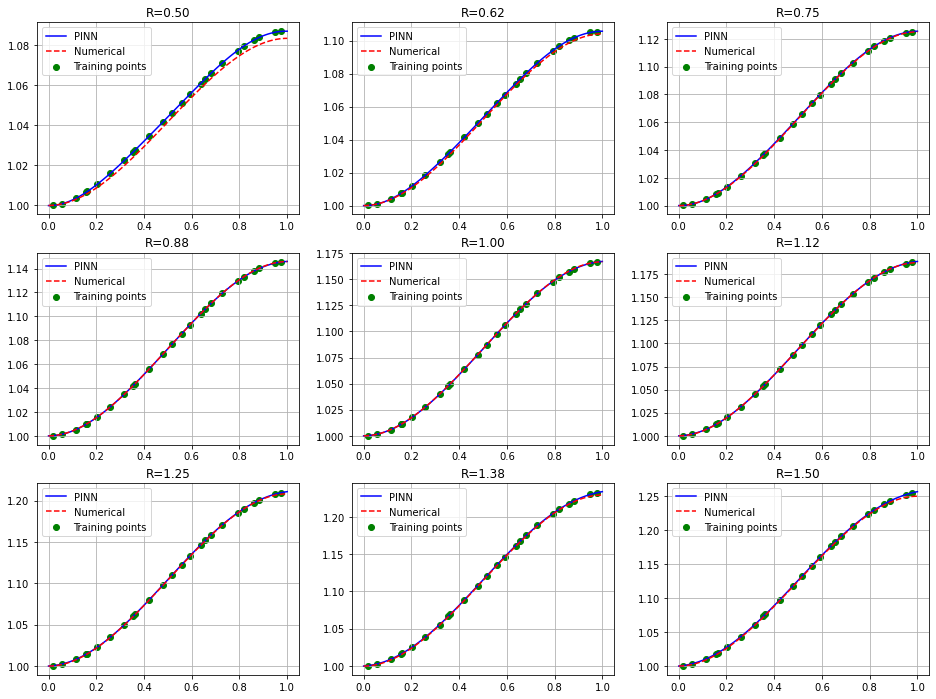

In [9]:
xTest = np.linspace(0, 1, 100)
RTestSet = np.linspace(0.5, 1.5, 9)

def logistic_eq_fn(x, y, R):
    return R * x * (1 - x)

checkPINN = plt.figure( figsize = (16,12) )

for mu in range(len(RTestSet)):
  R_0 = RTestSet[mu]
  R_in_NN = R_0 * np.ones((100,1))

  X_star = np.vstack([xTest, R_in_NN.flatten()]).T

  domain = [0.0, 1.0]
  numeric_solution = solve_ivp(
      logistic_eq_fn, domain, [1.], args = ([R_0]), t_eval=xTest
  )

  u_pred, f_pred = model.predict(X_star)

  Pt_Train = np.vstack([X_f_train[:,0], R_in_NN[:len(X_f_train[:,0])].flatten()]).T
  u_TrainPts, _= model.predict(Pt_Train)

  plt.subplot(3,3,mu+1)
  plt.scatter(X_f_train[:,0], u_TrainPts, label="Training points", color="g")
  plt.plot(xTest, u_pred,'b', label='PINN')
  plt.plot(xTest, numeric_solution.y.T, 'r--', label = 'Numerical')

  plt.legend()
  plt.title('R={:.2f}'.format(R_0))
  plt.grid(which='major',linestyle='-')
  plt.grid(which='minor',linestyle='--')